<a href="https://colab.research.google.com/github/Greta-gerasimov/PyT/blob/L8_GAN_PyT/L8_GAN_PyT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Обучить генератор создавать точки, которые будут лежать на графике функции**

y = sin(x)/x - x/10



При выполнении данного задания структура GAN остается той же, но Вам нужно:
1. Сгенерировать настоящие данные
2. Изменить архитектуру дискриминатора и генератора
3. Построить графики


In [ ]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch import FloatTensor
from torch.nn.functional import normalize

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
FUNC = lambda x: np.sin(x)/x - x/10

In [ ]:
MIN = -15
MAX = 15
NUM = 10000



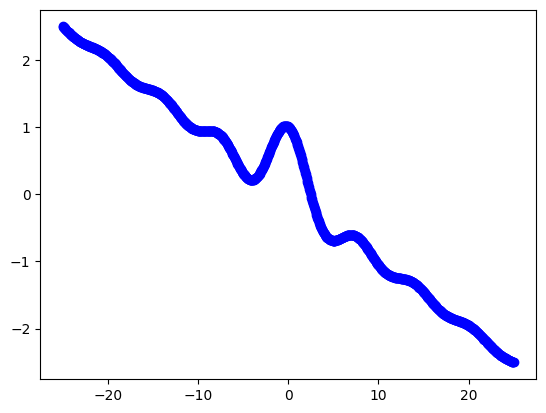

In [ ]:
x = np.linspace(-25, 25, 1000)
y = FUNC(x)
plt.plot(x, y, 'bo')
plt.show()

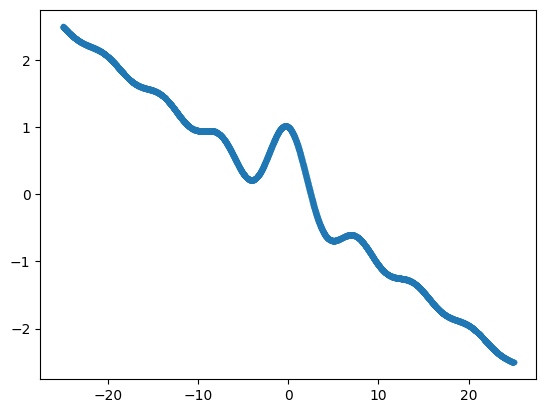

In [ ]:
train_points_length = 4096

train_points = torch.zeros((train_points_length, 2))
train_points[:, 0] = torch.Tensor(np.linspace(-25, 25, train_points_length))
# train_points[:, 0] = torch.Tensor(normalize(FloatTensor(np.linspace(-25, 25, train_points_length)), dim=0))

train_points[:, 1] = FUNC(train_points[:, 0])

plt.plot(train_points[:, 0], train_points[:, 1], '.')

In [ ]:
train_labels = torch.zeros(train_points_length)

train_tensor = [(train_points[i], train_labels[i]) for i in range(train_points_length)]
train_tensor[:5]

[(tensor([-25.0000,   2.4947]), tensor(0.)),
 (tensor([-24.9878,   2.4930]), tensor(0.)),
 (tensor([-24.9756,   2.4913]), tensor(0.)),
 (tensor([-24.9634,   2.4896]), tensor(0.)),
 (tensor([-24.9512,   2.4879]), tensor(0.))]

In [ ]:
batch_size=32
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)


In [ ]:
#dataiter = iter(train_loader)
#data_x = dataiter.next()
dataiter = iter(train_loader)
data_x = next(dataiter)
print(data_x)

[tensor([[  6.6972,  -0.6097],
        [  5.1099,  -0.6914],
        [ 13.1319,  -1.2724],
        [-18.0769,   1.7691],
        [  2.8022,  -0.1614],
        [ -3.9133,   0.2131],
        [ 13.4982,  -1.2904],
        [-17.6007,   1.7062],
        [-18.8339,   1.8826],
        [  6.2576,  -0.6298],
        [-22.1673,   2.2088],
        [ 16.9292,  -1.7484],
        [ 20.0549,  -1.9589],
        [ -9.0293,   0.9456],
        [  4.8291,  -0.6886],
        [-21.8742,   2.1928],
        [ 14.4750,  -1.3823],
        [ -1.3370,   0.8613],
        [ 24.5116,  -2.4749],
        [ -2.1551,   0.6026],
        [ -3.9866,   0.2110],
        [ 10.6777,  -1.1567],
        [ -4.9878,   0.3058],
        [  3.8889,  -0.5637],
        [ 20.5433,  -2.0060],
        [ -8.2967,   0.9386],
        [ -6.8071,   0.7542],
        [-17.5763,   1.7032],
        [ 16.5995,  -1.7068],
        [-23.1929,   2.2791],
        [-10.2259,   0.9524],
        [-23.7912,   2.3382]]), tensor([0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
n_epochs = 200  # количество эпох
lr = 0.001     # шаг обучения

b1 = 0.05        # гиперпараметр для оптимайзера Adam
b2 = 0.999      # гиперпараметр для оптимайзера Adam

latent_dim = 4    # Размерность случайного вектора, который подается на вход генератору
#hidden_dim = 64
sample_interval = 20  # количество итераций для отображения процесса обучения



#f_shape = 2    #  X и Y.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])

        def block(in_feat, out_feat, normalize=False, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.LeakyReLU()
        )


    def forward(self, z):
        points = self.model(z)

        return points

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, data_in):

        validity = self.model(data_in)

        return validity

In [ ]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# функция ошибки  общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

[Epoch 199/200] [Batch 108/128]|[D loss: 0.6561838388442993] [G loss: 0.8562902212142944]


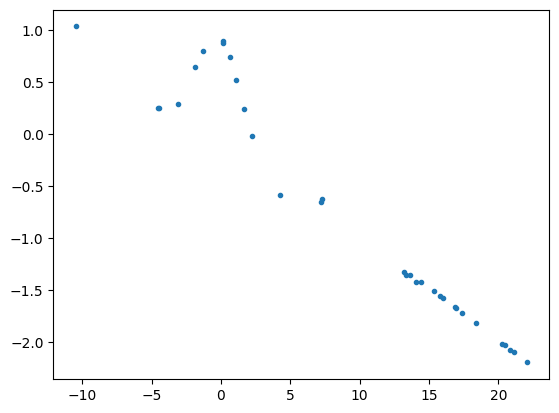

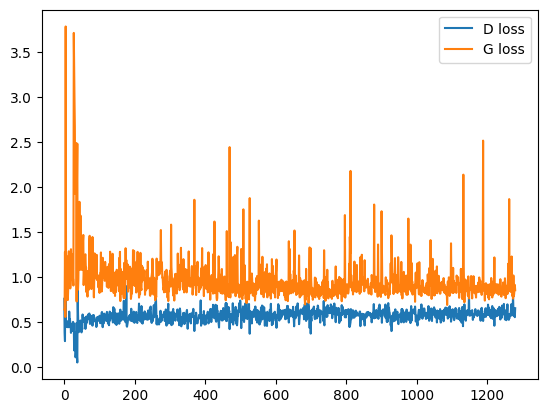

In [ ]:
import matplotlib.patches as mpatches

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)

######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_imgs)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################

        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_points)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)

                generated_samples = gen_points.detach().cpu()
                plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()

In [ ]:

######## Отображение процесса обучения и вывод функций потерь ############
         batches_done = epoch * len(train_loader) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)

                generated_samples = gen_points.detach().cpu()
                plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")


                print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(train_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(train_loader), 3)}')

                plt.figure(figsize = (10,5))
                plt.title('Prediction', fontsize = 20)
                plt.grid(True)
                plt.ylabel('Y', fontsize = 15)
                plt.xlabel('X', fontsize = 15)

               gen_data = gen_data.cpu().detach().numpy()
               plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

               plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

               plt.legend(fontsize = 15)
               plt.show()

d_loss_history.append(d_loss_mean / len(data_loader))
g_loss_history.append(g_loss_mean / len(data_loader))



    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')

        plt.figure(figsize = (10,5))
        plt.title('Prediction', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()

    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))